## Importing Libraries & Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
df = pd.read_csv('../input/spaceship-titanic/train.csv')
df_test_full = pd.read_csv('../input/spaceship-titanic/test.csv')

In [3]:
# finding out the non-null values and dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [4]:
# Reviewing Simple statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,8514.0,28.827930,14.489021,0.0,19.0,27.0,38.0,79.0
RoomService,8512.0,224.687617,666.717663,0.0,0.0,0.0,47.0,14327.0
FoodCourt,8510.0,458.077203,1611.489240,0.0,0.0,0.0,76.0,29813.0
ShoppingMall,8485.0,173.729169,604.696458,0.0,0.0,0.0,27.0,23492.0
Spa,8510.0,311.138778,1136.705535,0.0,0.0,0.0,59.0,22408.0
VRDeck,8505.0,304.854791,1145.717189,0.0,0.0,0.0,46.0,24133.0


In [5]:
# Defining the train and target variables
y = df['Transported']
df_full = df.drop(['Transported'],axis=1)
ids = df_test_full['PassengerId'] #Get the test ids for the final submission

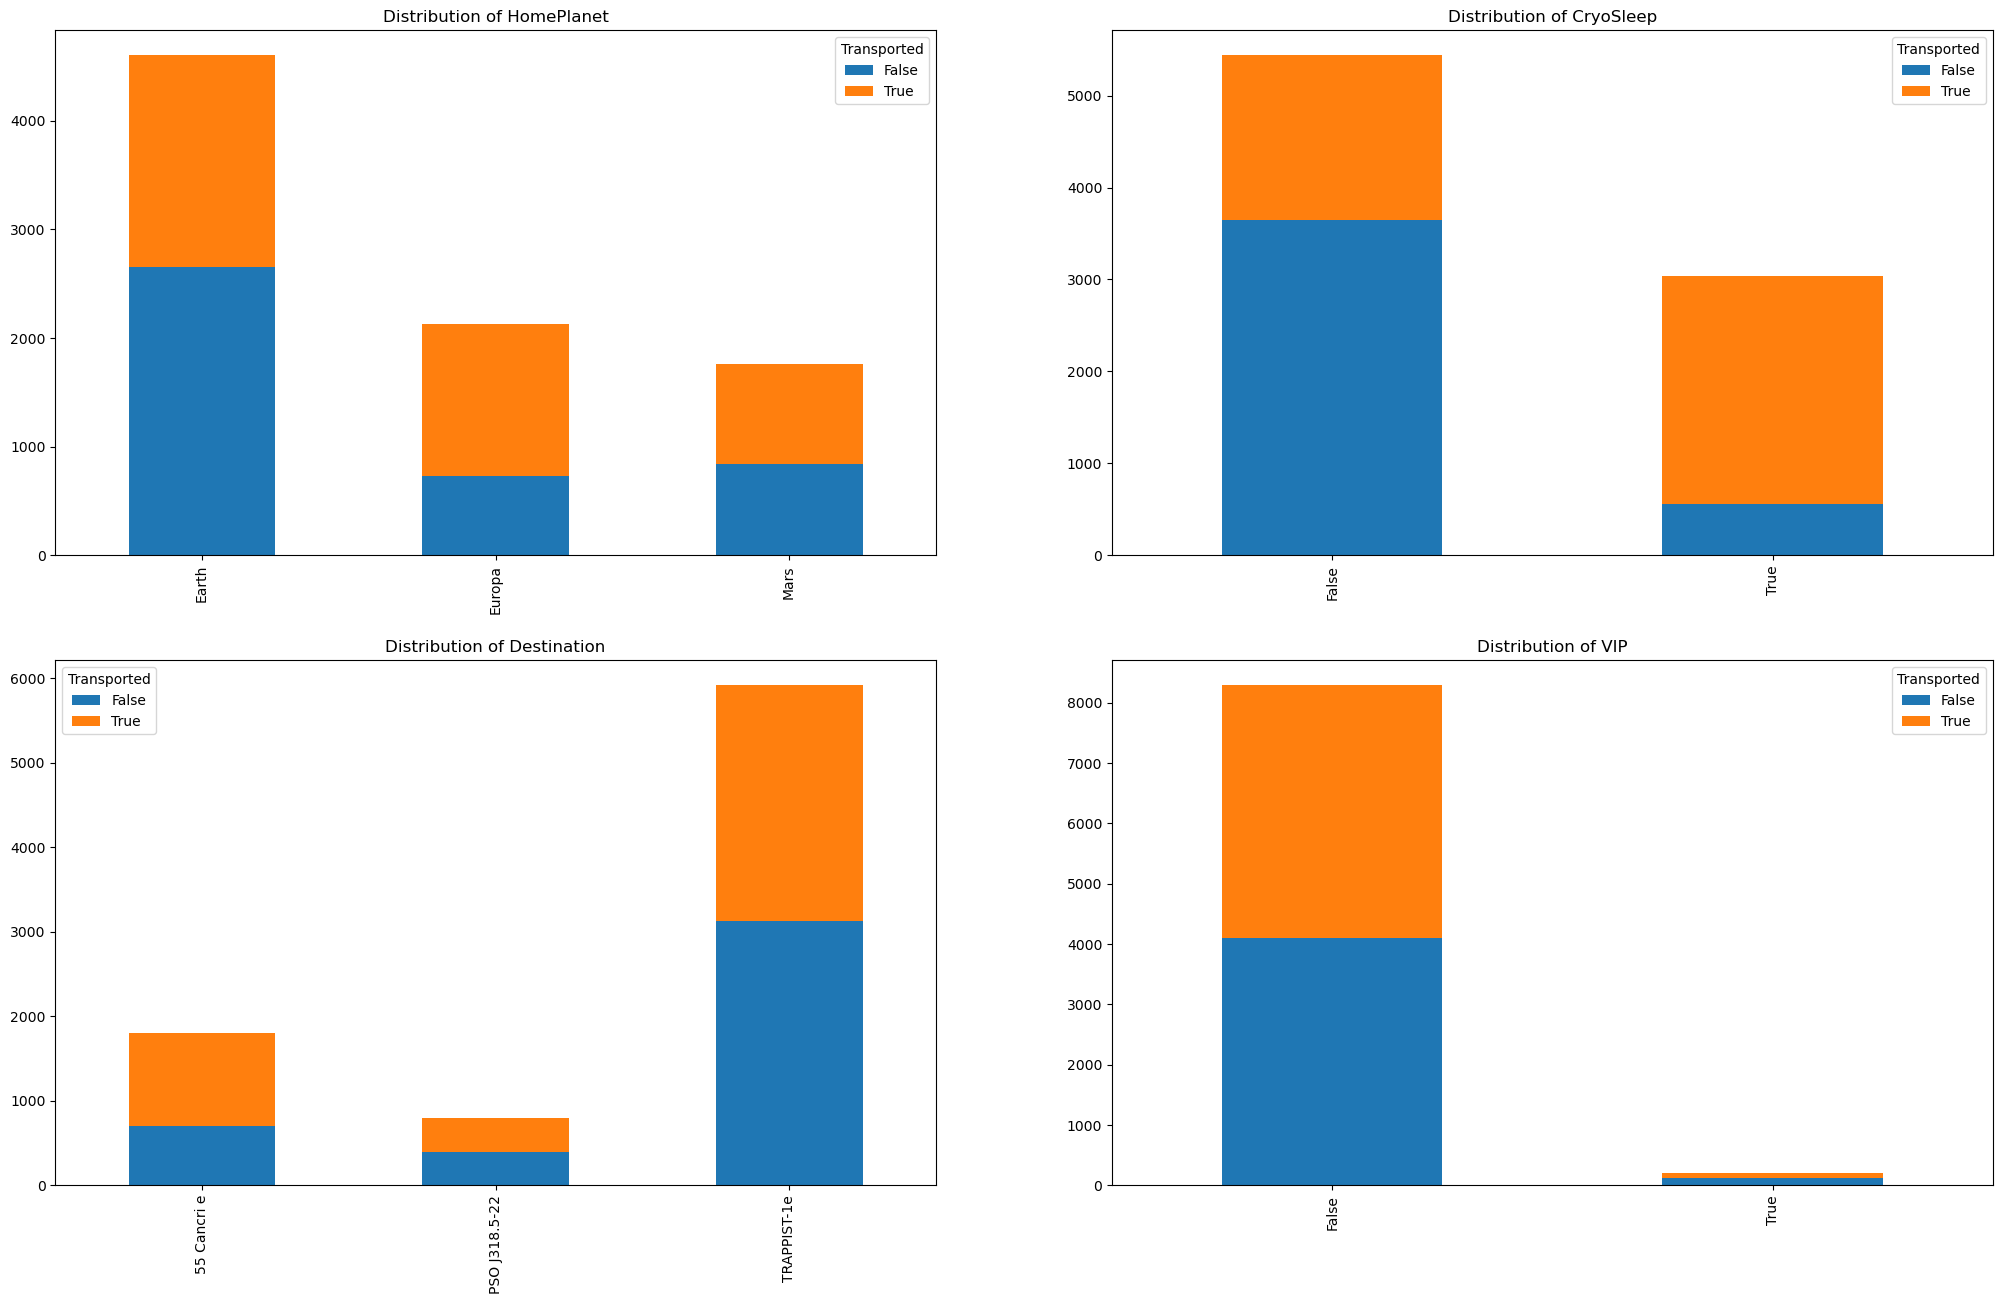

In [6]:
# Looking at different variables distributions to decide how to fillna
categorical_col = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
plt.figure(figsize=(25,15))

for i, col in enumerate(categorical_col):
    plt.subplot(2,2,i+1)
    p1 = df.groupby(col)["Transported"].value_counts().unstack().plot(kind="bar", stacked=True, ax=plt.gca())
    plt.title("Distribution of "+col)
    plt.xlabel("")

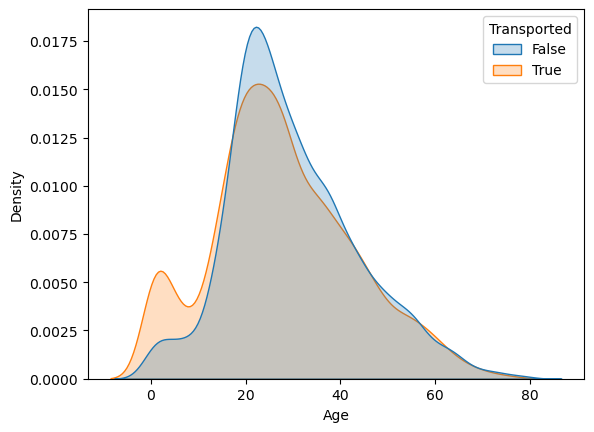

In [7]:
sns.kdeplot(data=df, x="Age", hue="Transported", shade=True)
plt.show()

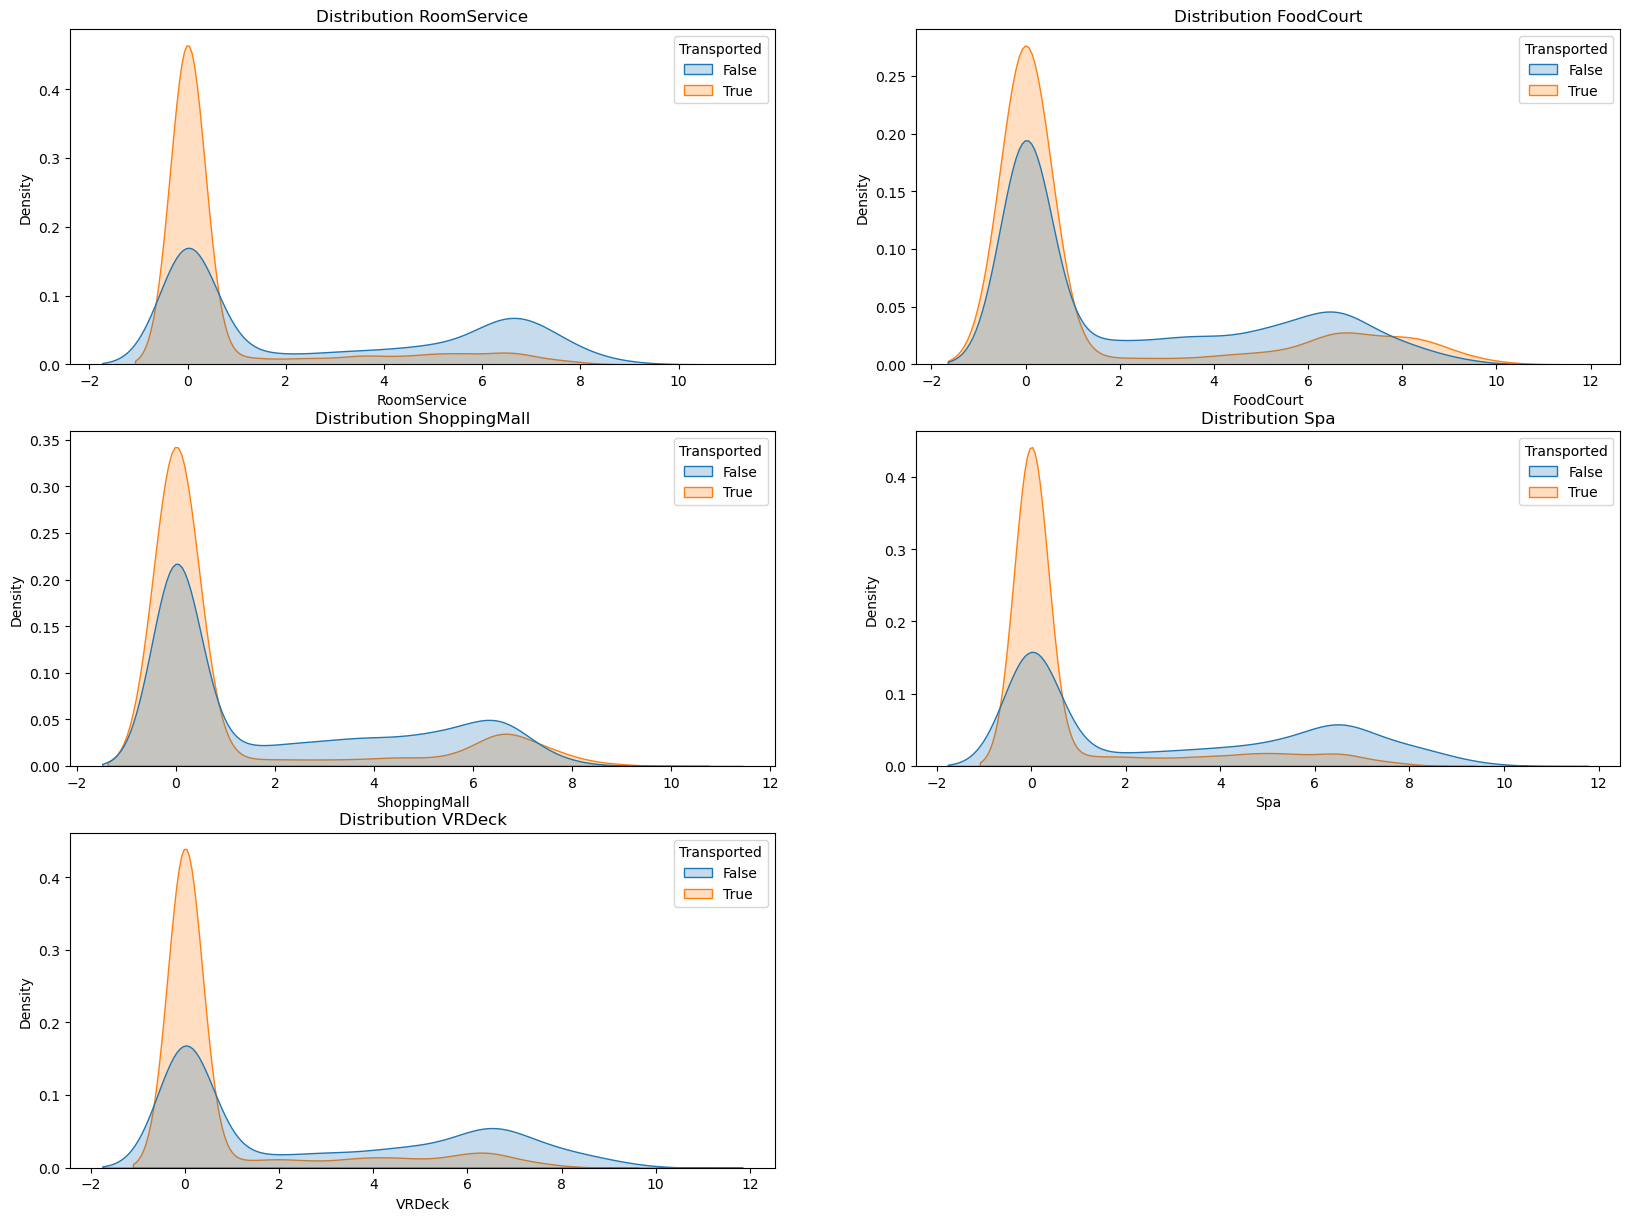

In [8]:
log_train = df.copy()
numeric_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

log_train[numeric_cols] = log_train[numeric_cols].apply(lambda col: np.log(col+1), axis=1)

plt.figure(figsize=(20,20))
for i, col in enumerate(numeric_cols):
    plt.subplot(4,2,i+1)
    sns.kdeplot(data=log_train, x=col, hue="Transported", shade=True)# common_norm=False,
    plt.xlabel(col)#, fontsize=12)
    plt.title("Distribution "+col)#, fontsize=16)

## Preprocessing

****Handling Categorical Columns****

In [9]:
# Reviewing the categorical variables
object_cols = [col for col in df_full.columns if df_full[col].dtype == 'object']
object_nunique = list(map(lambda col:df_full[col].nunique(),object_cols))
d = dict(zip(object_cols,object_nunique))
sorted(d.items(), key=lambda x:x[1])

[('CryoSleep', 2),
 ('VIP', 2),
 ('HomePlanet', 3),
 ('Destination', 3),
 ('Cabin', 6560),
 ('Name', 8473),
 ('PassengerId', 8693)]

In [10]:
# mapping the boolean variables
df_full[['VIP','CryoSleep']].apply(lambda x: x.unique())

,VIP,CryoSleep
0,False,False
1,True,True
2,NaN,NaN


In [11]:
df_full['VIP'] = df_full['VIP'].map({False: 0, True: 1})
df_full['CryoSleep'] = df_full['CryoSleep'].map({False: 0, True: 1})

In [12]:
# Selecting columns for the One hot encoding
low_cardinality_cols = [col for col in df_full.columns if df_full[col].nunique()<10]
high_cardinality_cols = list(set(object_cols)-set(low_cardinality_cols))
print('One-hot encoding Categorical columns:{}\t\t \nDropping Categorical columns:{}'.format(low_cardinality_cols,high_cardinality_cols))

One-hot encoding Categorical columns:['HomePlanet', 'CryoSleep', 'Destination', 'VIP']		 
Dropping Categorical columns:['Name', 'Cabin', 'PassengerId']


****Creating new features for training and test datasets****

In [13]:
# Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with,so creating new feature Group
df_full['Group'] = df_full['PassengerId'].str.extract('(\d\d\d\d)_',expand=True).astype('int64')
# Cabin got three values deck/num/side, so creating three columns for each
df_full['Deck'] = df_full['Cabin'].str.extract('(\w)/',expand=True)
df_full['Side'] = df_full['Cabin'].str.extract('/(\D)',expand=True)
# Total amount of money spent on each of the Spaceship Titanic's many luxury amenities
df_full['Bill'] = df_full['RoomService'] + df_full['FoodCourt'] + df_full['ShoppingMall']+\
df_full['Spa']+df_full['VRDeck']

df_test_full['Group'] = df_test_full['PassengerId'].str.extract('(\d\d\d\d)_',expand=True).astype('int64')
df_test_full['Deck'] = df_test_full['Cabin'].str.extract('(\w)/',expand=True)
df_test_full['Side'] = df_test_full['Cabin'].str.extract('/(\D)',expand=True)
df_test_full['Bill'] = df_test_full['RoomService'] + df_test_full['FoodCourt'] + df_test_full['ShoppingMall']+\
df_test_full['Spa']+df_test_full['VRDeck']

In [14]:
categorical_cols = [cname for cname in df_full.columns if df_full[cname].nunique()<10 and
                   df_full[cname].dtype =='object']
numerical_cols = [cname for cname in df_full.columns if df_full[cname].dtype in ['int64','float64']]

****Reviewing with Missing Values****

In [15]:
missing_value_count = (df_full.isnull().sum())
print(missing_value_count[missing_value_count>0])

HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Deck            199
Side            199
Bill            908
dtype: int64


## Split Train & Test Data

In [17]:
# Break off validation set from training data
from sklearn.model_selection import train_test_split
X_train_full, X_valid_full, y_train, y_valid = train_test_split(df_full, y, train_size= 0.8, random_state=0)

In [18]:
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = df_test_full[my_cols].copy()

## XGBoost Model Hyperparameter Selection

****Imputing numerical columns for model selection****

In [20]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
my_imputer = SimpleImputer(strategy='most_frequent')
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train))
imputed_X_train.index = X_train.index
imputed_X_train.columns = X_train.columns.astype(str)

****Imputing categorical columns for model selection****

In [21]:
for col in categorical_cols:
    dummies = pd.get_dummies(imputed_X_train[col])
    imputed_X_train.drop(col,axis=1, inplace=True)
    final_X_train = pd.concat([imputed_X_train, dummies], axis=1)
final_X_train = final_X_train.astype('float64')

****Performing GridSearch for hyperparameter selection****

In [22]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
##
parameters = [{'n_estimators':[50,500],'learning_rate':[0.05,0.01,0.1]}]
model = XGBClassifier()


Grid = GridSearchCV(model,parameters,cv=5)
Grid.fit(final_X_train,y_train)
Grid.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

## Creating Pipeline for Imputaion, OH Encoding, XGBoost Model

In [23]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy ='mean')
 # Preprocessing for categorical data
categorical_transformer = Pipeline(steps =[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer,numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])
preprocessor.fit_transform(X_train,y_train)
X_eval = preprocessor.transform(X_valid)
#X_test = preprocessor.transform(X_test)

In [25]:
from sklearn.metrics import mean_absolute_error
# Bundle preprocessing and modeling code in a pipeline
eval_set = [(X_eval, y_valid)]
model = XGBClassifier(n_estimators = 50, learning_rate= 0.1, random_state = 0)
my_pipeline = Pipeline(steps = [('preprocessor',preprocessor),('model', model)])
my_pipeline.fit(X_train, y_train, model__early_stopping_rounds=20, model__eval_set=eval_set)
print(f'Training Score : {my_pipeline.score(X_train,y_train):.2f}')
preds = my_pipeline.predict(X_valid)
score = mean_absolute_error(y_valid , preds)
print("MAE:", score)

[0]	validation_0-logloss:0.65323
[1]	validation_0-logloss:0.62050
[2]	validation_0-logloss:0.59301
[3]	validation_0-logloss:0.56992
[4]	validation_0-logloss:0.55032
[5]	validation_0-logloss:0.53323
[6]	validation_0-logloss:0.51822


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-logloss:0.50567
[8]	validation_0-logloss:0.49454
[9]	validation_0-logloss:0.48458
[10]	validation_0-logloss:0.47627
[11]	validation_0-logloss:0.46882
[12]	validation_0-logloss:0.46225
[13]	validation_0-logloss:0.45615
[14]	validation_0-logloss:0.45084
[15]	validation_0-logloss:0.44595
[16]	validation_0-logloss:0.44178
[17]	validation_0-logloss:0.43669
[18]	validation_0-logloss:0.43366
[19]	validation_0-logloss:0.43125
[20]	validation_0-logloss:0.42755
[21]	validation_0-logloss:0.42556
[22]	validation_0-logloss:0.42282
[23]	validation_0-logloss:0.42099
[24]	validation_0-logloss:0.41969
[25]	validation_0-logloss:0.41842
[26]	validation_0-logloss:0.41640
[27]	validation_0-logloss:0.41478
[28]	validation_0-logloss:0.41346
[29]	validation_0-logloss:0.41238
[30]	validation_0-logloss:0.41136
[31]	validation_0-logloss:0.41027
[32]	validation_0-logloss:0.40875
[33]	validation_0-logloss:0.40799
[34]	validation_0-logloss:0.40684
[35]	validation_0-logloss:0.40669
[36]	validation_0

In [26]:
model_output = model.get_booster().get_score(importance_type = 'weight')
model_output_dict = {X_train.columns[i]:float(model_output.get('f'+str(i))) for i in range(len(X_train.columns))}
feature_importance = sorted(model_output_dict.items(),key = lambda x: x[1],reverse=True)
feature_importance_result = pd.DataFrame(feature_importance, columns=['Feature','weight'])
feature_importance_result

,Feature,weight
0,FoodCourt,381.0
1,Destination,236.0
2,RoomService,222.0
3,CryoSleep,192.0
4,VIP,184.0
5,ShoppingMall,141.0
6,Side,123.0
7,Age,98.0
8,HomePlanet,46.0
9,Spa,45.0


In [27]:
results = my_pipeline.predict(X_test)
final_df=pd.DataFrame({'Passengerid':ids,'Transported':results})
final_df.to_csv('submission.csv',index=False)